<a href="https://colab.research.google.com/github/paragrafff22/SkyTasks/blob/SkyTests/HotOrDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.model_selection import train_test_split

import os

Using TensorFlow backend.


In [2]:
cd '/content/drive/My Drive/img_test/data_3/train'

/content/drive/My Drive/img_test/data_3/train


In [0]:
path_train = '/content/drive/My Drive/img_test/data_3/train'
path_test = '/content/drive/My Drive/img_test/data_3/test'

Data preparation

In [0]:
filenames = os.listdir(path_train)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if 'dog' in category:
        categories.append("dog")
    else:
        categories.append("hot")

In [0]:
df = pd.DataFrame({
    'names': filenames,
    'labels': categories
})

In [6]:
df.head()


,names,labels
0,dog_144.png,dog
1,dog_316.png,dog
2,dog_53.png,dog
3,dog_444.png,dog
4,dog_188.png,dog


In [7]:
df.tail()

,names,labels
995,hot_337.png,hot
996,hot_18.png,hot
997,hot_124.png,hot
998,hot_132.png,hot
999,model_image_classification.h5,hot


Look on data

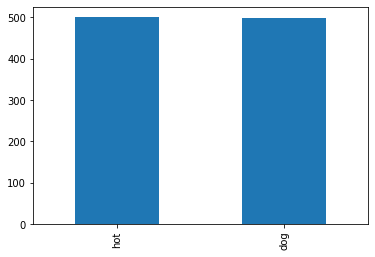

In [8]:
df['labels'].value_counts().plot.bar()

In [0]:
X_train, y_train = train_test_split(df, test_size=0.2, random_state=42)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)



In [10]:
X_train['labels'].value_counts()

dog    400
hot    400
Name: labels, dtype: int64

In [11]:
y_train['labels'].value_counts()


hot    101
dog     99
Name: labels, dtype: int64

Image preprocessing

In [12]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    X_train, 
    path_train,
    x_col='names',
    y_col='labels',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=10
)

Found 799 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="names". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [13]:
validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    y_train, 
    path_train, 
    x_col='names',
    y_col='labels',
    target_size=(128,128),
    class_mode='categorical',
    batch_size=10
)



Found 200 validated image filenames belonging to 2 classes.


In [14]:
example_df = X_train.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    path_train, 
    x_col='names',
    y_col='labels',
    target_size=(128,128),
    class_mode='categorical'
)


Found 1 validated image filenames belonging to 1 classes.


Example of image preprocessing

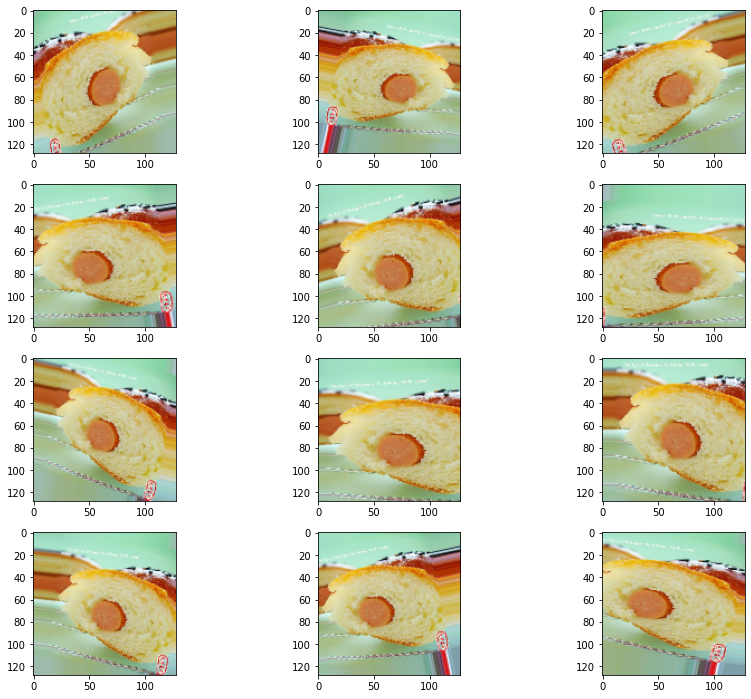

In [15]:
plt.figure(figsize=(12, 12))
for i in range(0, 12):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,BatchNormalization

def get_model(input_shape, num_classes):
  return Sequential((
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax'),
))



Hyperparameters

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]



Get and compile model

In [18]:
model = get_model(input_shape=(128,128,3), num_classes=2)
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

Fit model with generator

In [19]:
history = model.fit_generator(
    train_generator, 
    epochs=23,
    validation_data=validation_generator,
    callbacks = callbacks
    )


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/23
80/80 [==============================] - 10s 126ms/step - loss: 0.7111 - accuracy: 0.6333 - val_loss: 0.4844 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 2/23
80/80 [==============================] - 10s 126ms/step - loss: 0.3908 - accuracy: 0.8348 - val_loss: 0.3759 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 3/23
80/80 [==============================] - 10s 125ms/step - loss: 0.3604 - accuracy: 0.8586 - val_loss: 0.3590 - val_accuracy: 0.8350 - lr: 0.0010
Epoch 4/23
80/80 [==============================] - 10s 125ms/step - loss: 0.3835 - accuracy: 0.8486 - val_loss: 0.3262 - val_accuracy: 0.8800 - lr: 0.0010
Epoch 5/23
80/80 [==============================] - 10s 125ms/step - loss: 0.3715 - accuracy: 0.8573 - val_loss: 0.3679 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 6/23
80/80 [==============================] - 10s 126ms/step - loss: 0.3480 - accuracy: 0.8448 - val_loss: 0.3392 - val_accuracy: 0.8900 -

Preparing testing data

In [0]:
test_filenames = os.listdir(path_test)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]


In [21]:
test_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    path_test, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(128,128),
    shuffle=False
)


Found 604 validated image filenames.


Prediticion

In [22]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/32))

Instructions for updating:
Please use Model.predict, which supports generators.


In [0]:
test_df['category'] = np.argmax(predict, axis=-1)

In [0]:
test_df['category'] = test_df['category'].replace({ 0 : "dog", 1 : "hot" })

In [25]:
test_df

,filename,category
0,hot_739.png,hot
1,hot_606.png,hot
2,hot_775.png,dog
3,hot_565.png,hot
4,hot_588.png,hot
...,...,...
599,hot_503.png,hot
600,hot_649.png,hot
601,hot_780.png,hot
602,hot_617.png,hot


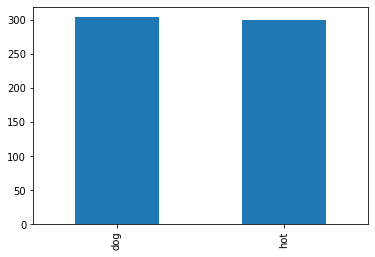

In [26]:
test_df['category'].value_counts().plot.bar()

Visualization training and validation


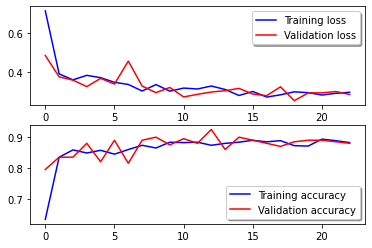

In [27]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

Examples of prediction

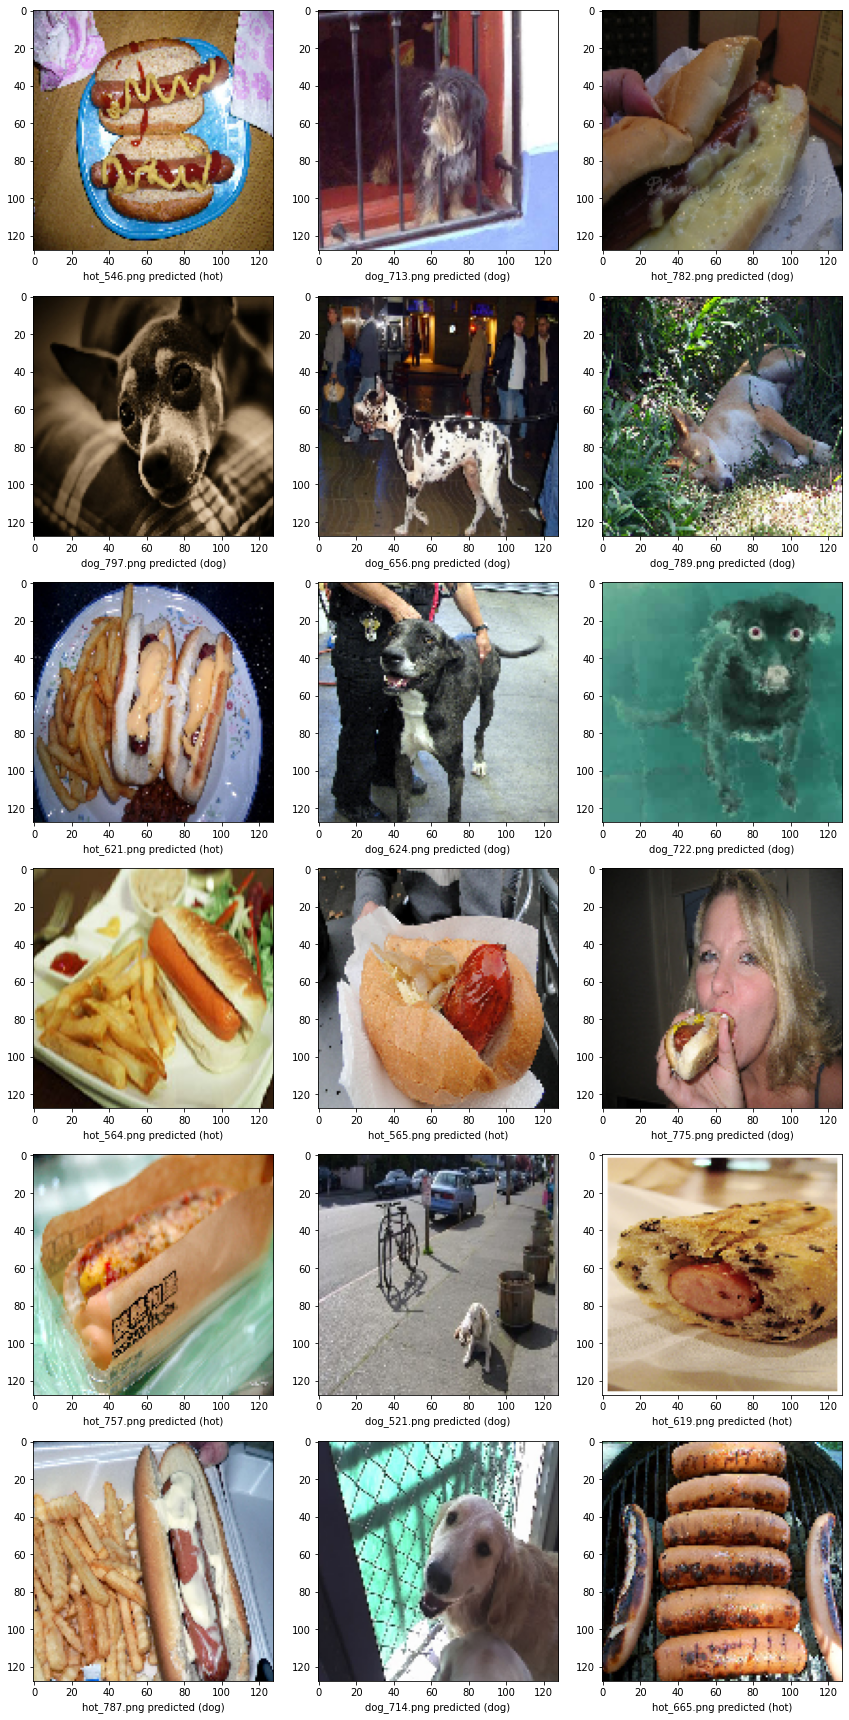

In [28]:
test_df = test_df.sample(frac=1)
test_df.reset_index(drop=True, inplace=True)
sample_test = test_df.head(18)

sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = keras.preprocessing.image.load_img(path_test+ '/' +filename, target_size=(128,128))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + ' predicted (' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()


Confusion Matrix

In [0]:
from sklearn.metrics import confusion_matrix
conf_predict = list(test_df['category'].replace({ "dog" : 0, "hot" : 1}))
conf_true = []
for filename in test_df['filename']:
  if "dog" in filename:
    conf_true.append(1)
  else:
    conf_true.append(0)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


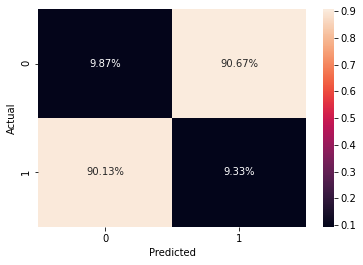

In [30]:
import seaborn as sn
data = {'y_Actual':    conf_true,
        'y_Predicted': conf_predict
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix/np.sum(confusion_matrix), annot=True, fmt='.2%') 
plt.show()

Save model

In [0]:
model.save('model_image_classification.h5')
json_string = model.to_json()